[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['label', 'Agricultural Equipment Services', 'Soil Nutrient Application Services', 'Pesticide Application Services', 'Ornamental Plant Nurseries', 'Landscaping Services', 'Gardening Services', 'Tree Services - Pruning / Removal', 'Veterinary Services', 'Veterinary Clinics', 'Pet Boarding Services', 'Animal Day Care Services', 'Pet Grooming Services', 'Animal Training Services', 'Veterinary Health Centers', 'Animal Trainers', 'Livestock Dealer Services', 'Timber Harvesting Operations', 'Fishing and Hunting Services', 'Well Maintenance Services', 'Field Welding Services', 'Sand and Gravel Mining', 'Residential Driveway Construction', 'Commercial Driveway Construction', 'Fencing Construction Services', 'Sidewalk Construction Services', 'Commercial Irrigation Systems', 'Residential Drainage Systems', 'Residential Snow Removal', 'Commercial Snow Removal', 'General Snow Removal Services', 'Land Leveling Services', 'Residential Drain Cleaning', 'Commercial Drain Cleaning', 'Street Cleaning Op

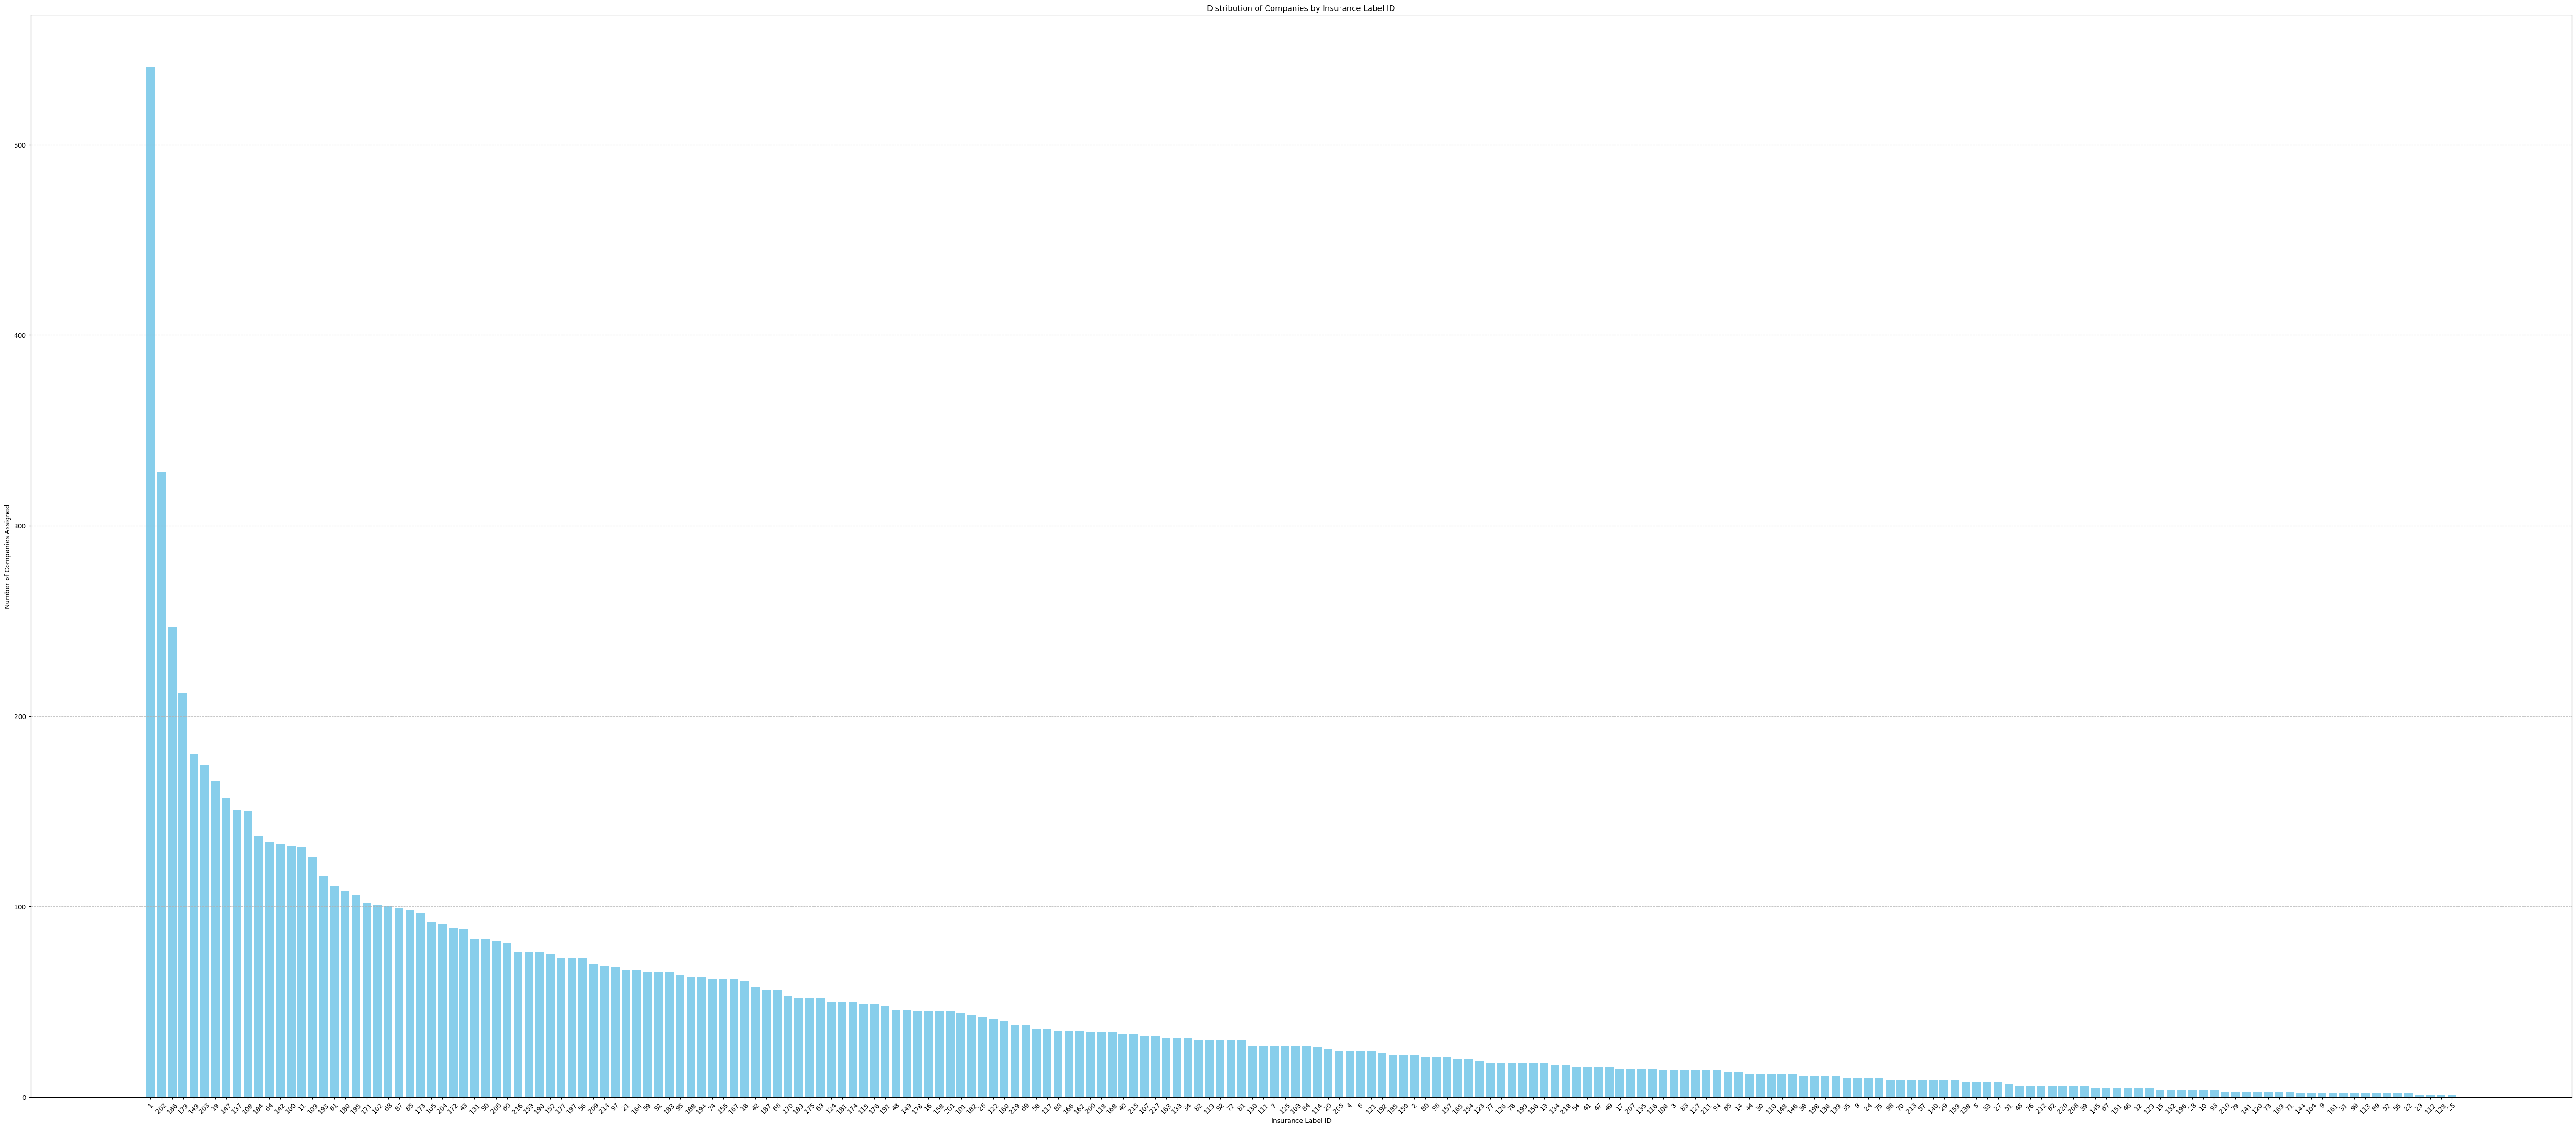

Results saved to company_insurance_classification.csv
Agricultural Equipment Services (ID: 1) - 541 companies
Health and Safety Consulting (ID: 202) - 328 companies
Training Services (ID: 186) - 247 companies
Business Development Services (ID: 179) - 212 companies
Paper Production Services (ID: 149) - 180 companies
Food Safety Services (ID: 203) - 174 companies
Well Maintenance Services (ID: 19) - 166 companies
Furniture Manufacturing (ID: 147) - 157 companies
Children's Clothing Manufacturing (ID: 137) - 151 companies
Mobile Home Construction Services (ID: 108) - 150 companies
Market Research Services (ID: 184) - 137 companies
Water Treatment Services (ID: 64) - 134 companies
Wood Product Manufacturing (ID: 142) - 133 companies
Building Cleaning Services (ID: 100) - 132 companies
Animal Day Care Services (ID: 11) - 131 companies
Commercial Construction Services (ID: 109) - 126 companies
Online Marketing Services (ID: 193) - 116 companies
HVAC Installation and Service (ID: 61) - 111 co

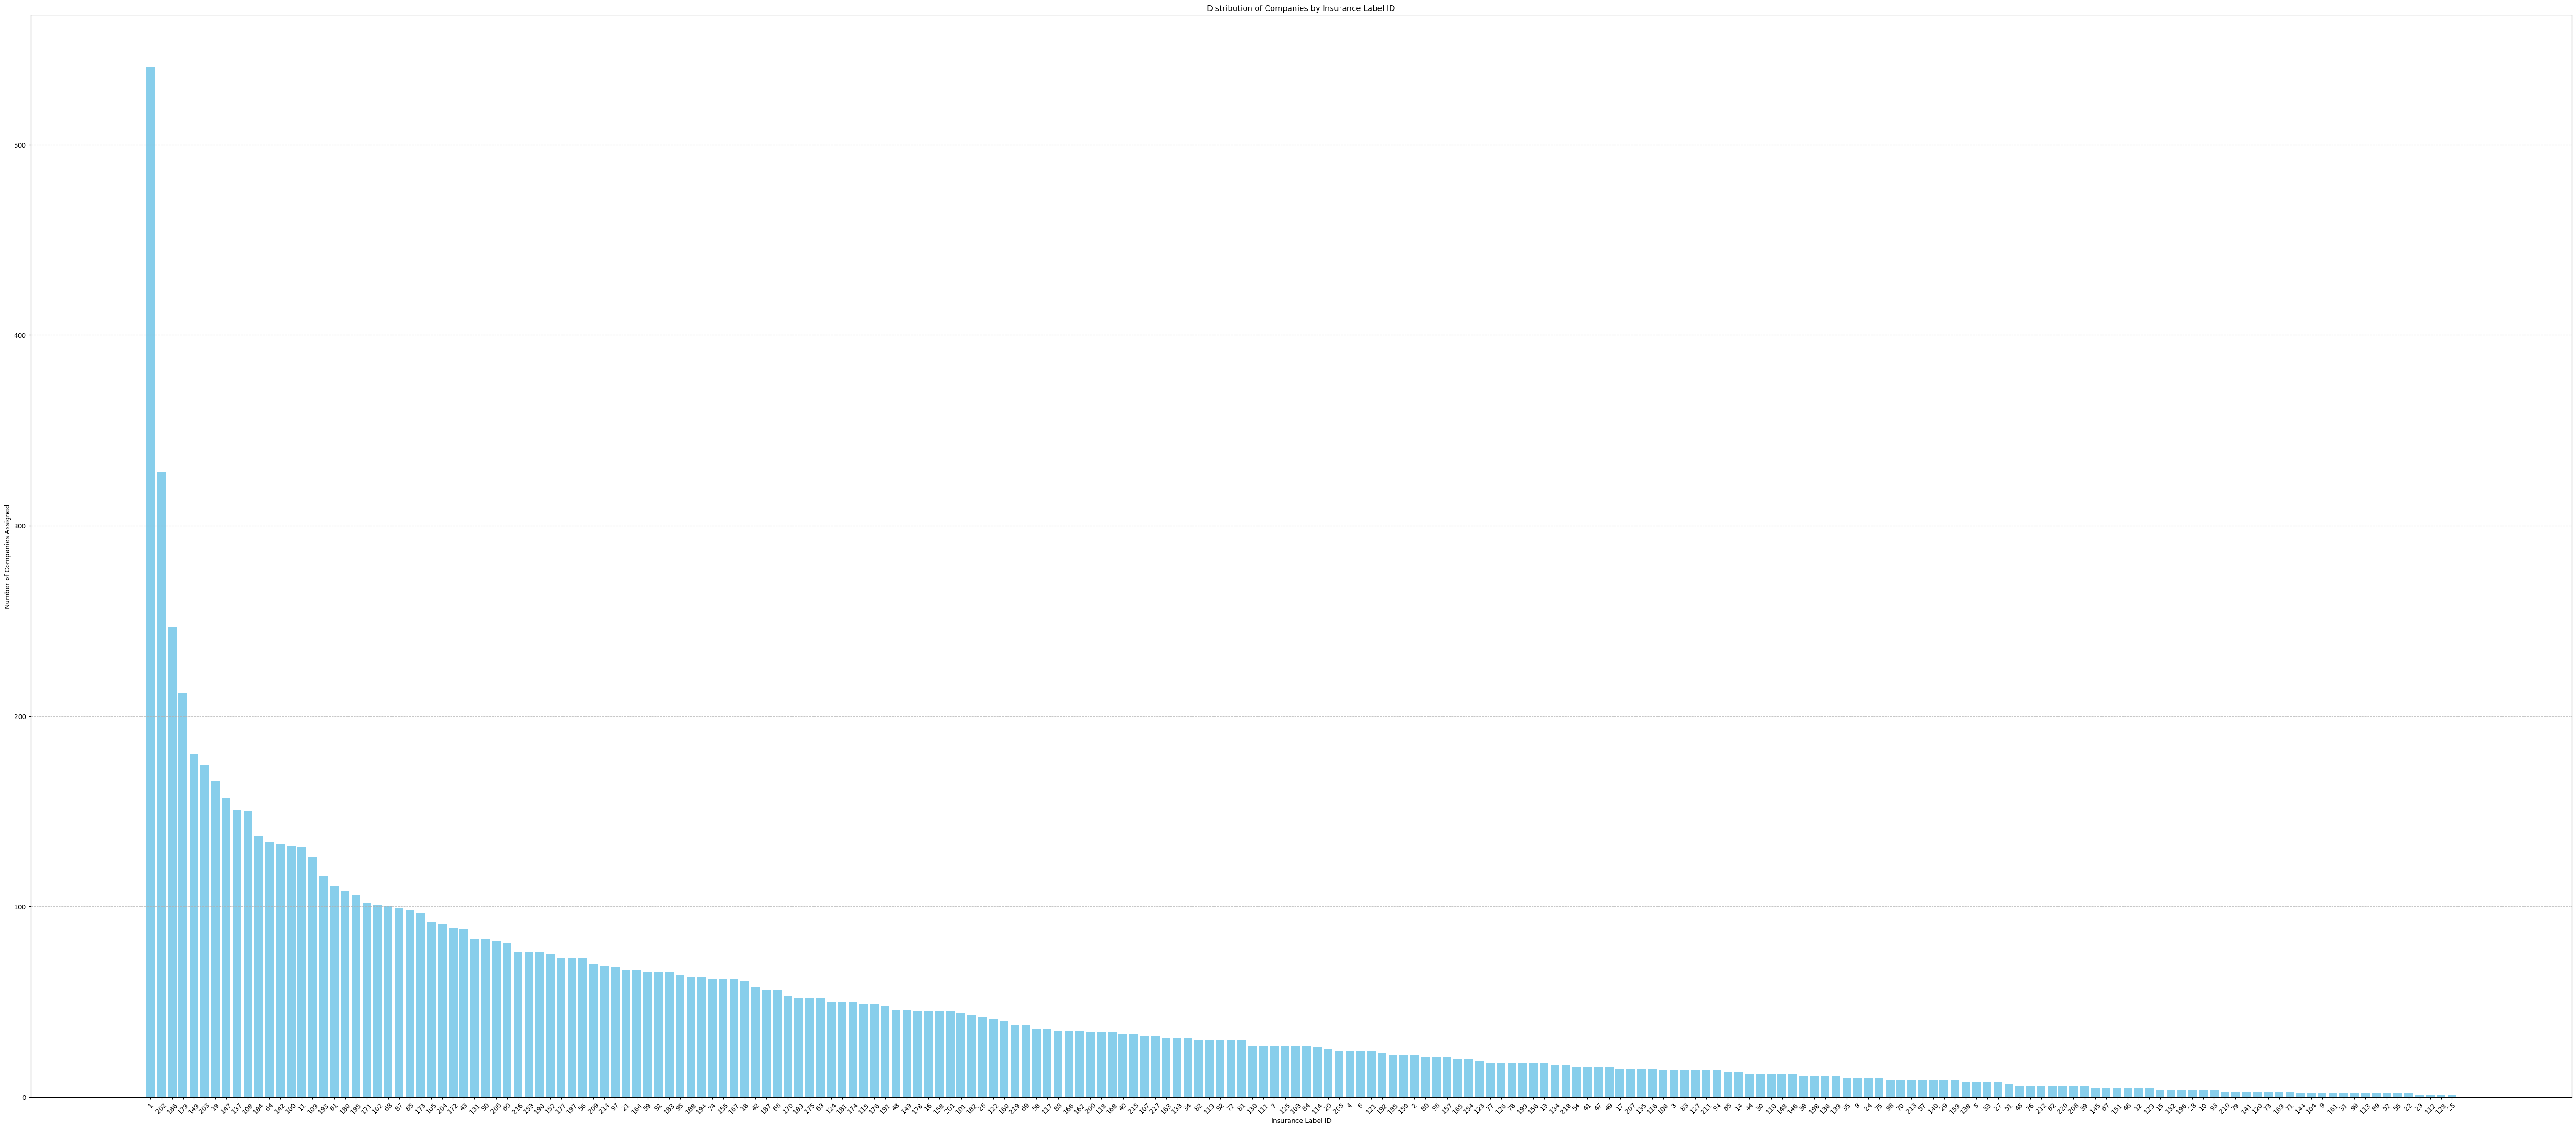

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # For progress tracking

# Ensure necessary NLTK resources are available
import nltk
nltk.data.path.append("/usr/local/share/nltk_data")  # Adjust this path if necessary
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Step 1: Load company dataset
company_df = pd.read_csv("ml_insurance_challenge.csv")
# Step 2: Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
print(insurance_labels)
#remove the first element
insurance_labels = insurance_labels[1:]
print(insurance_labels)
# Step 3: Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

#Print the label to id mapping
print(label_to_id)
print(id_to_label)

#show the label of id 5
print(id_to_label[5])
# Step 4: Load GloVe word embeddings
def load_glove_embeddings(filepath, dim=300):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings("glove.6B.300d.txt")
def text_to_glove_vector(text, glove_embeddings):
    words = text.split()  # Simple tokenization
    vectors = [glove_embeddings.get(word, np.zeros(300)) for word in words]  # Default to zero vector if word is unknown
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)
# Step 5: Preprocess text descriptions
def preprocess_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = re.findall(r'\b\w+\b', text)  # Alternative tokenization method
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)
def preprocess_all_columns(row):
    # Combine text from all relevant columns into one string
    combined_text = " ".join([str(row[col]) for col in ['business_tags', "niche", "category", "description"]])
    
    # Preprocess the combined text
    return preprocess_text(combined_text)
company_df['processed_combined_text'] = company_df.apply(preprocess_all_columns, axis=1)
company_df['glove_vector'] = company_df['processed_combined_text'].apply(lambda x: text_to_glove_vector(x, glove_embeddings))
# Step 8: Convert insurance labels to vectors
insurance_label_vectors = np.vstack([text_to_glove_vector(label, glove_embeddings) for label in insurance_labels])
# Step 9: Compute cosine similarity between company descriptions and insurance labels
company_vectors = np.vstack(company_df['glove_vector'].values)
similarity_matrix = cosine_similarity(company_vectors, insurance_label_vectors)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Step 2: Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
# Remove the first element
insurance_labels = insurance_labels[1:]

# Step 3: Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

# Print the label to id mapping
print(label_to_id)
print(id_to_label)

# Show the label of id 5
print(id_to_label[5])

# Load your actual company data
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with your actual data file

# Fill missing values in the 'description' column with an empty string
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
# Generate the similarity matrix using TF-IDF and cosine similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Re-run the assignment
company_df['insurance_label_id'] = assign_labels(
    similarity_matrix, insurance_labels, label_to_id
)

# Count the occurrences of each label ID
label_counts = company_df['insurance_label_id'].value_counts()

# Print the label name with the label id and the number of companies assigned to that label
for label in label_counts.index:
    print(id_to_label[int(label)])
    print(f"id: {label}, label Counts: {label_counts[label]}")

# Create a bar chart
plt.figure(figsize=(70, 30))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
insurance_labels = insurance_labels[1:]  # Remove the first element

# Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

# Load company data
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with actual data file

# Fill missing values in the 'description' column with an empty string
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

# Compute similarity matrix
similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Assign labels
company_df['insurance_label_id'] = assign_labels(similarity_matrix, insurance_labels, label_to_id)

# Map label IDs back to label names
company_df['insurance_label_name'] = company_df['insurance_label_id'].map(id_to_label)

# Save results to a CSV file
output_file = "company_insurance_classification.csv"
company_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

# Count occurrences of each label ID
label_counts = company_df['insurance_label_id'].value_counts()

# Print label statistics
for label in label_counts.index:
    print(f"{id_to_label[int(label)]} (ID: {label}) - {label_counts[label]} companies")

# Create a bar chart
plt.figure(figsize=(70, 30))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alessiacolumban/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Results saved to company_insurance_classification_tfidf.csv
Agricultural Equipment Services (ID: 1) - 742 companies
Wood Product Manufacturing (ID: 142) - 346 companies
HVAC Installation and Service (ID: 61) - 235 companies
Business Development Services (ID: 179) - 193 companies
Accessory Manufacturing (ID: 136) - 193 companies
Pet Food Manufacturing (ID: 122) - 174 companies
Electric Line Construction (ID: 68) - 167 companies
Mobile Home Construction Services (ID: 108) - 161 companies
Animal Day Care Services (ID: 11) - 145 companies
Paper Production Services (ID: 149) - 142 companies
Technology Consulting (ID: 181) - 139 companies
Industrial Machinery Installation (ID: 43) - 138 companies
Event Planning Services (ID: 188) - 137 companies
Market Research Services (ID: 184) - 124 companies
Sheet Metal Services (ID: 87) - 123 companies
Furniture Manufacturing (ID: 147) - 121 companies
Online Marketing Services (ID: 193) - 120 companies
Building Cleaning Services (ID: 100) - 116 companie

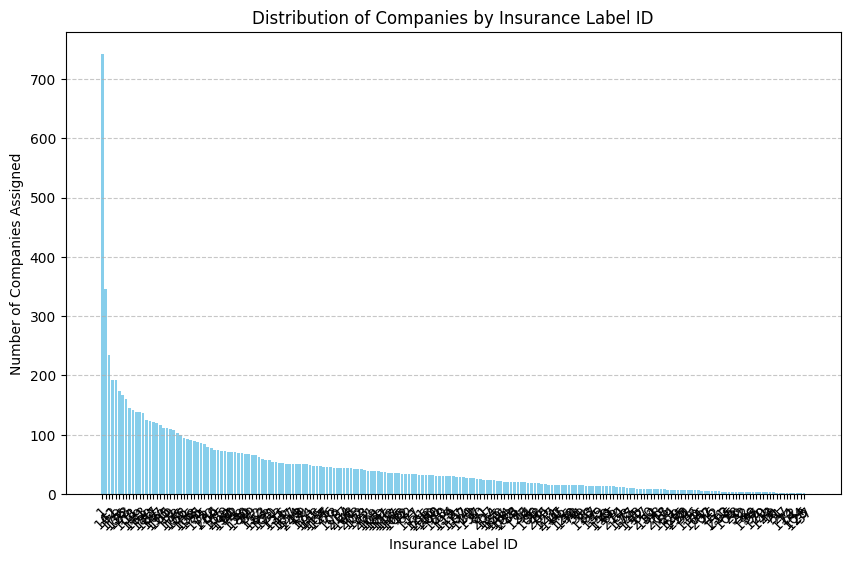

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Step 1: Load company dataset
company_df = pd.read_csv("ml_insurance_challenge.csv")

# Step 2: Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()

# Remove the first element (if it's not a valid label)
insurance_labels = insurance_labels[1:]

# Step 3: Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

# Step 4: Preprocess text descriptions
def preprocess_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = re.findall(r'\b\w+\b', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

company_df['processed_description'] = company_df['description'].apply(preprocess_text)

# Step 5: Vectorize the company descriptions and insurance labels using TF-IDF
vectorizer = TfidfVectorizer()
combined_texts = company_df['processed_description'].tolist() + insurance_labels

# Fit the vectorizer on both company descriptions and insurance labels
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Separate the company and label TF-IDF matrices
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

# Step 6: Compute cosine similarity between company descriptions and insurance labels
similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Step 7: Assign insurance labels based on highest similarity
def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Assign labels to companies
company_df['insurance_label_id'] = assign_labels(similarity_matrix, insurance_labels, label_to_id)

# Map label IDs back to label names
company_df['insurance_label_name'] = company_df['insurance_label_id'].map(id_to_label)

# Save results to a CSV file
output_file = "company_insurance_classification_tfidf.csv"
company_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

# Count occurrences of each label ID
label_counts = company_df['insurance_label_id'].value_counts()

# Print label statistics
for label in label_counts.index:
    print(f"{id_to_label[int(label)]} (ID: {label}) - {label_counts[label]} companies")

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


{'Agricultural Equipment Services': 1, 'Soil Nutrient Application Services': 2, 'Pesticide Application Services': 3, 'Ornamental Plant Nurseries': 4, 'Landscaping Services': 5, 'Gardening Services': 6, 'Tree Services - Pruning / Removal': 7, 'Veterinary Services': 8, 'Veterinary Clinics': 9, 'Pet Boarding Services': 10, 'Animal Day Care Services': 11, 'Pet Grooming Services': 12, 'Animal Training Services': 13, 'Veterinary Health Centers': 14, 'Animal Trainers': 15, 'Livestock Dealer Services': 16, 'Timber Harvesting Operations': 17, 'Fishing and Hunting Services': 18, 'Well Maintenance Services': 19, 'Field Welding Services': 20, 'Sand and Gravel Mining': 21, 'Residential Driveway Construction': 22, 'Commercial Driveway Construction': 23, 'Fencing Construction Services': 24, 'Sidewalk Construction Services': 25, 'Commercial Irrigation Systems': 26, 'Residential Drainage Systems': 27, 'Residential Snow Removal': 28, 'Commercial Snow Removal': 29, 'General Snow Removal Services': 30, 'L

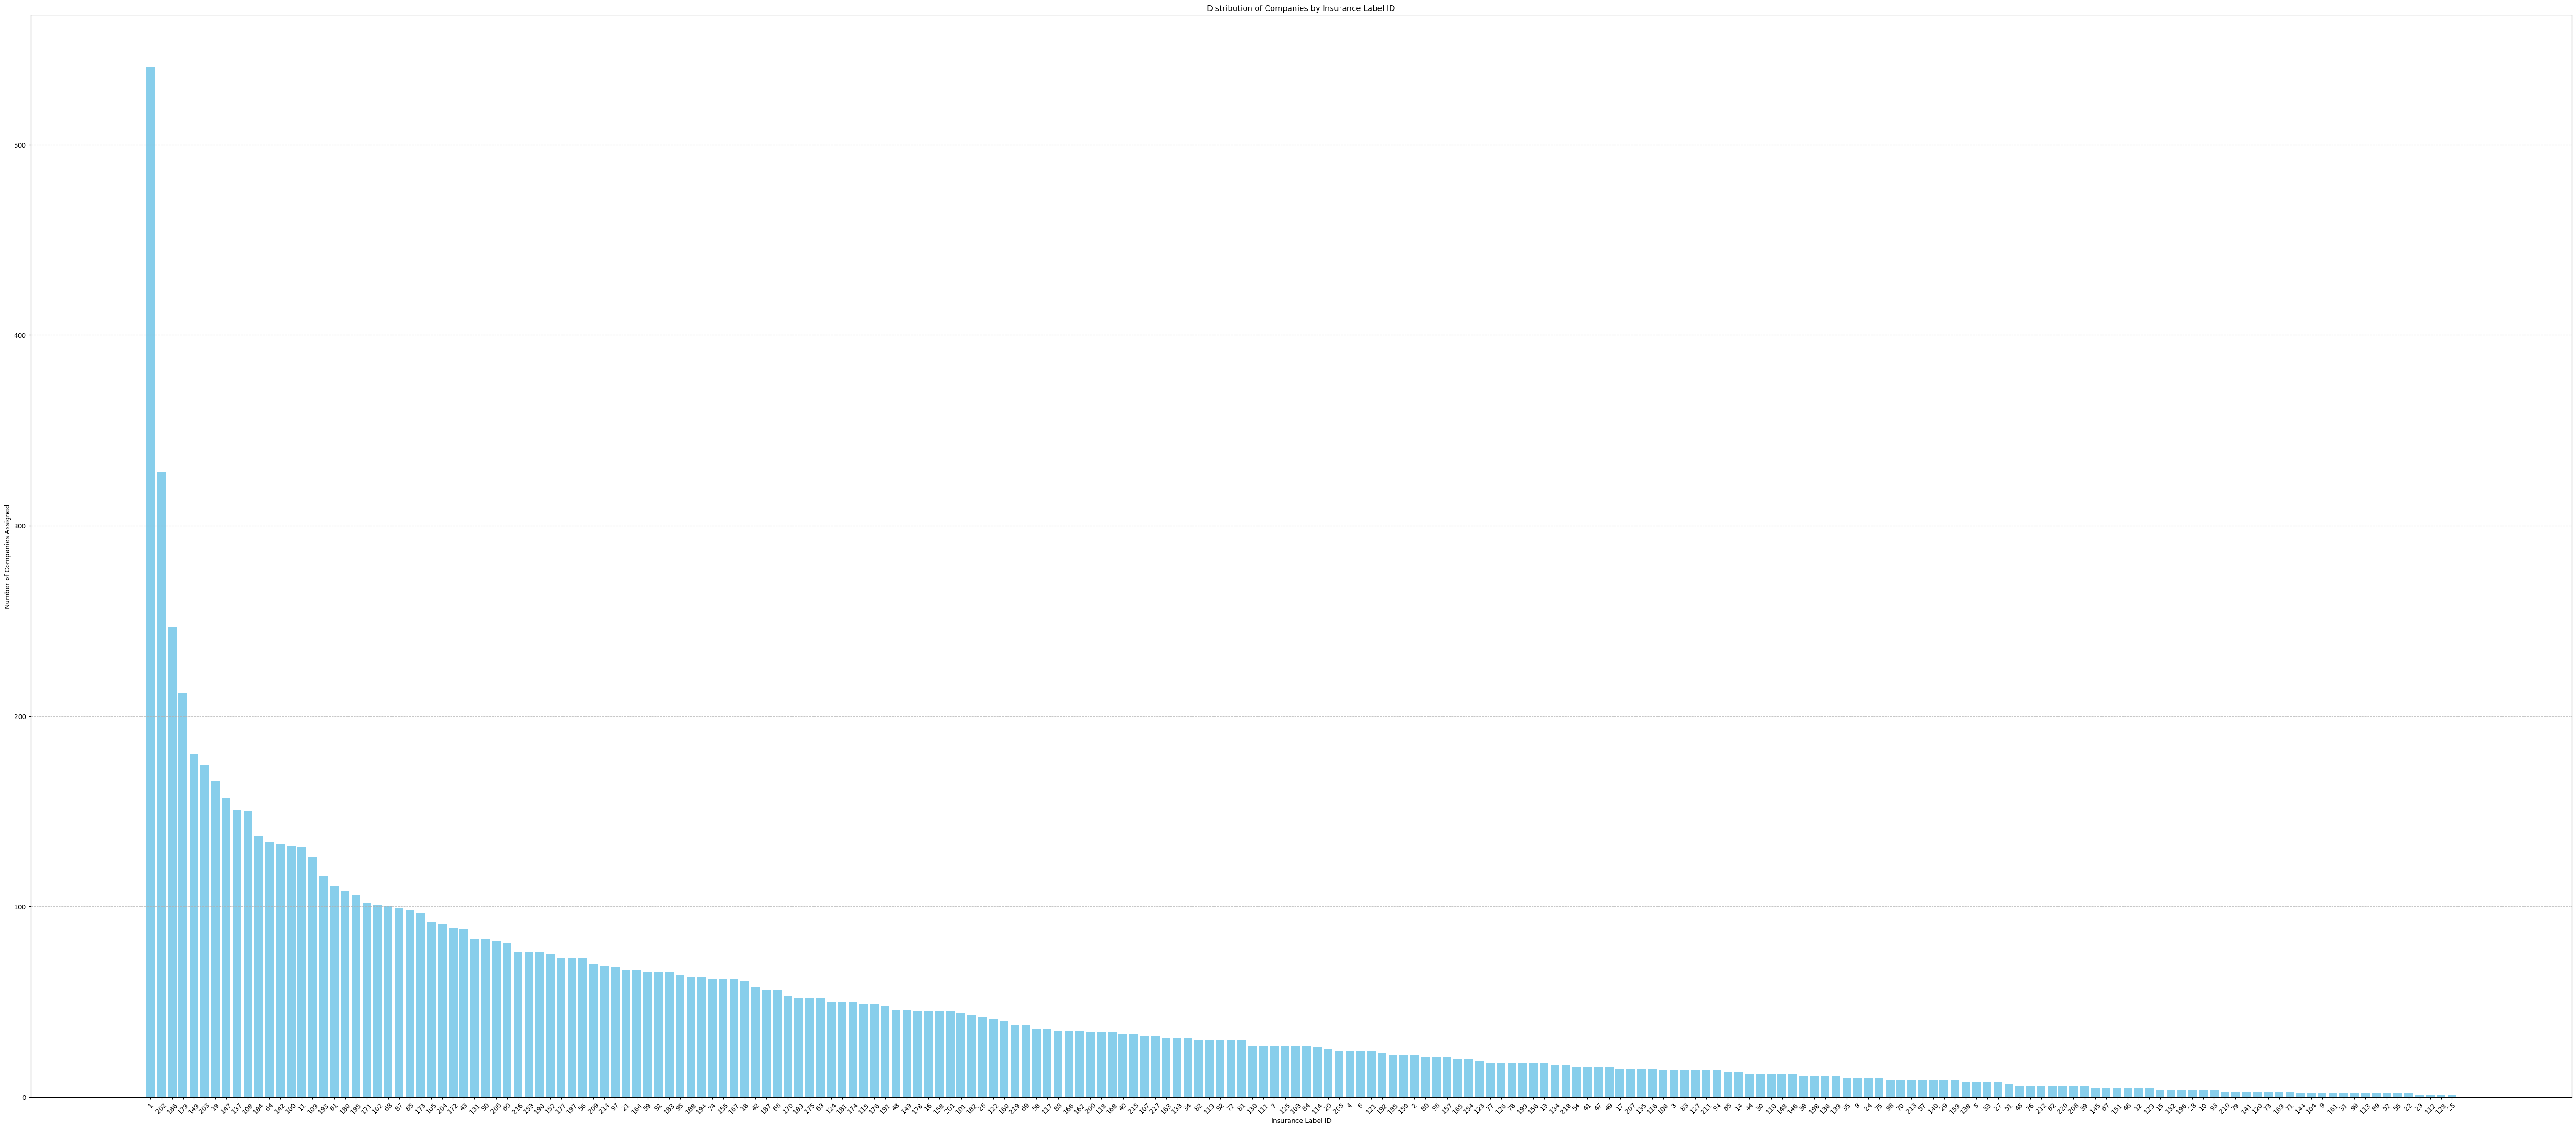

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Step 2: Load insurance taxonomy labels with corresponding insurance types
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()
# Remove the first element
insurance_labels = insurance_labels[1:]

# Step 3: Assign numerical labels to insurance categories
label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}

# Print the label to id mapping
print(label_to_id)
print(id_to_label)

# Show the label of id 5
print(id_to_label[5])

# Load your actual company data
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with your actual data file

# Fill missing values in the 'description' column with an empty string
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
# Generate the similarity matrix using TF-IDF and cosine similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Re-run the assignment
company_df['insurance_label_id'] = assign_labels(
    similarity_matrix, insurance_labels, label_to_id
)

# Count the occurrences of each label ID
label_counts = company_df['insurance_label_id'].value_counts()

# Print the label name with the label id and the number of companies assigned to that label
for label in label_counts.index:
    print(id_to_label[int(label)])
    print(f"id: {label}, label Counts: {label_counts[label]}")

# Create a bar chart
plt.figure(figsize=(70, 30))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Epoch 1/5
119/119 - 13s - loss: 4.9235 - accuracy: 0.0539 - val_loss: 4.8535 - val_accuracy: 0.0590 - 13s/epoch - 108ms/step
Epoch 2/5
119/119 - 11s - loss: 4.8140 - accuracy: 0.0564 - val_loss: 4.8257 - val_accuracy: 0.0590 - 11s/epoch - 91ms/step
Epoch 3/5
119/119 - 12s - loss: 4.8228 - accuracy: 0.0560 - val_loss: 4.8409 - val_accuracy: 0.0590 - 12s/epoch - 101ms/step
Epoch 4/5
119/119 - 11s - loss: 4.7874 - accuracy: 0.0573 - val_loss: 4.8464 - val_accuracy: 0.0595 - 11s/epoch - 91ms/step
Epoch 5/5
119/119 - 11s - loss: 4.7542 - accuracy: 0.0614 - val_loss: 4.8238 - val_accuracy: 0.0611 - 11s/epoch - 90ms/step
Model accuracy: 7.00%
149/149 [==============================] - 3s 21ms/step
Results saved to company_insurance_classification_with_lstm.csv
Health and Safety Consulting (ID: 201) - 4387 companies
Agricultural Equipment Services (ID: 0) - 2635 companies
Project Management Services (ID: 179) - 1270 companies
Food Safety Services (ID: 202) - 676 companies
Water Treatment Servi

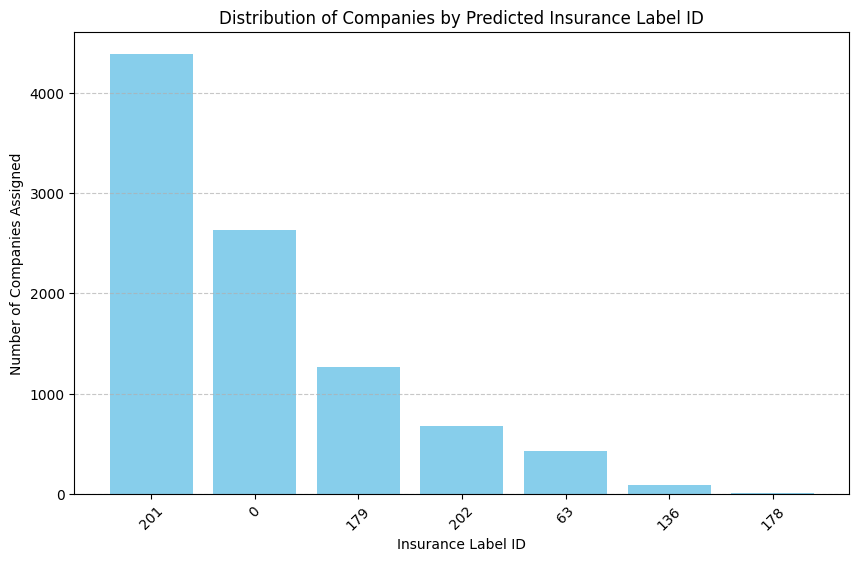

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

# Function to assign labels based on the similarity matrix
def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Prepare insurance taxonomy labels
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()[1:]  # Remove the first element

label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
# id_to_label = {idx + 1: label for idx, label in enumerate(insurance_labels)}
id_to_label = {idx: label for idx, label in enumerate(insurance_labels)}

# Load company data and preprocess descriptions
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with actual data file
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

# Compute similarity matrix
similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Assign labels based on similarity
company_df['insurance_label_id'] = assign_labels(similarity_matrix, insurance_labels, label_to_id)

# Map insurance label IDs to label names
# company_df['insurance_label_name'] = company_df['insurance_label_id'].map(id_to_label)


# Subtract 1 from insurance_label_id to make it zero-indexed
company_df['insurance_label_id'] = company_df['insurance_label_id'] - 1

# Now one-hot encode the labels for multi-class classification
y_lstm = company_df['insurance_label_id'].values
y_lstm = to_categorical(y_lstm, num_classes=len(insurance_labels))  # One-hot encode with correct class size

# Now we have the 'insurance_label_id' column in the DataFrame, proceed with LSTM

# Preprocess the descriptions for LSTM
def preprocess_text_for_lstm(df, max_words=5000, max_len=100):
    tokenizer = Tokenizer(num_words=max_words, lower=True)
    tokenizer.fit_on_texts(df['description'])
    sequences = tokenizer.texts_to_sequences(df['description'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences, tokenizer

# Prepare data for LSTM
X_lstm, tokenizer = preprocess_text_for_lstm(company_df)

# Map insurance labels to numeric values for training
y_lstm = company_df['insurance_label_id'].values

# One-hot encode the labels for multi-class classification
y_lstm = to_categorical(y_lstm, num_classes=len(insurance_labels))  # One-hot encode with correct class size

# Build the LSTM model for multi-class classification
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(insurance_labels), activation='softmax'))  # Multi-class softmax activation

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_lstm, y_lstm, epochs=5, batch_size=64, validation_split=0.2, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_lstm, y_lstm, verbose=0)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Predict the labels
predictions = model.predict(X_lstm, batch_size=64)
predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Map predicted labels back to insurance categories
company_df['predicted_label_id'] = predicted_labels
company_df['predicted_label_name'] = company_df['predicted_label_id'].map(id_to_label)

# Save results to a CSV file
output_file = "company_insurance_classification_with_lstm.csv"
company_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Count occurrences of each predicted label ID
label_counts = company_df['predicted_label_id'].value_counts()

# Print label statistics
for label in label_counts.index:
    print(f"{id_to_label[int(label)]} (ID: {label}) - {label_counts[label]} companies")

# Create a bar chart of the predicted labels
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Predicted Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Epoch 1/5
119/119 - 39s - loss: 4.8386 - accuracy: 0.0587 - val_loss: 4.7467 - val_accuracy: 0.0664 - 39s/epoch - 325ms/step
Epoch 2/5
119/119 - 38s - loss: 4.5929 - accuracy: 0.0778 - val_loss: 4.6704 - val_accuracy: 0.0679 - 38s/epoch - 322ms/step
Epoch 3/5
119/119 - 40s - loss: 4.3833 - accuracy: 0.0897 - val_loss: 4.5122 - val_accuracy: 0.0806 - 40s/epoch - 340ms/step
Epoch 4/5
119/119 - 36s - loss: 4.1791 - accuracy: 0.1059 - val_loss: 4.4093 - val_accuracy: 0.0890 - 36s/epoch - 305ms/step
Epoch 5/5
119/119 - 41s - loss: 3.9407 - accuracy: 0.1359 - val_loss: 4.3222 - val_accuracy: 0.1006 - 41s/epoch - 345ms/step
Model accuracy: 15.81%
149/149 [==============================] - 12s 79ms/step
Results saved to company_insurance_classification_with_lstm.csv
Food Safety Services (ID: 202) - 1803 companies
Agricultural Equipment Services (ID: 0) - 1066 companies
Project Management Services (ID: 179) - 738 companies
Paper Production Services (ID: 148) - 733 companies
Furniture Manufactur

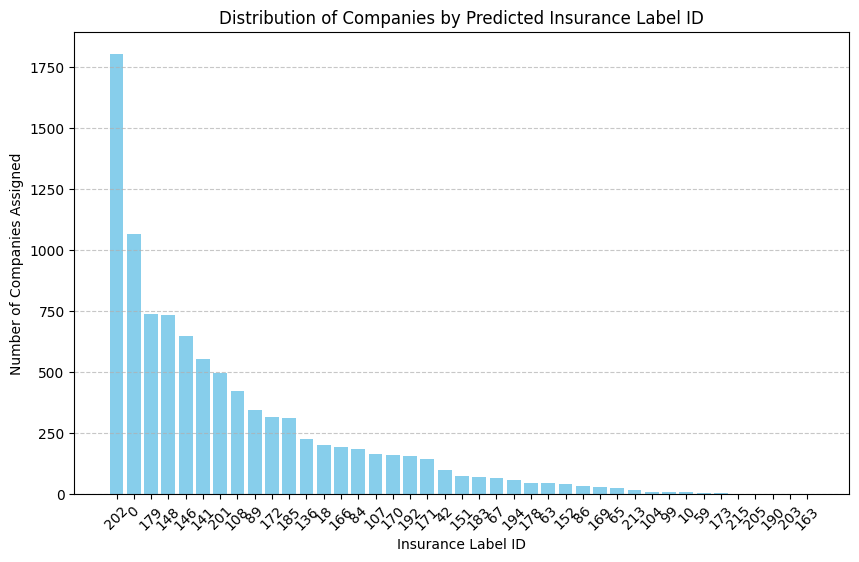

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Function to assign labels based on the similarity matrix
def assign_labels(similarity_matrix, labels, label_to_id):
    top_indices = np.argmax(similarity_matrix, axis=1)
    
    assigned_labels = []
    
    for index in top_indices:
        # Assign labels as numeric values
        numeric_label = label_to_id.get(labels[index], -1)
        assigned_labels.append(numeric_label)
    
    return assigned_labels

# Prepare insurance taxonomy labels
insurance_labels_df = pd.read_excel("insurance_taxonomy.xlsx", header=None, names=["Label"])
insurance_labels = insurance_labels_df["Label"].tolist()[1:]  # Remove the first element

label_to_id = {label: idx + 1 for idx, label in enumerate(insurance_labels)}
id_to_label = {idx: label for idx, label in enumerate(insurance_labels)}

# Load company data and preprocess descriptions
company_df = pd.read_csv("ml_insurance_challenge.csv")  # Replace with actual data file
company_df['description'] = company_df['description'].fillna('')

# Combine company descriptions with insurance labels for TF-IDF vectorization
combined_texts = company_df['description'].tolist() + insurance_labels
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)
company_tfidf = tfidf_matrix[:len(company_df)]
label_tfidf = tfidf_matrix[len(company_df):]

# Compute similarity matrix
similarity_matrix = cosine_similarity(company_tfidf, label_tfidf)

# Assign labels based on similarity
company_df['insurance_label_id'] = assign_labels(similarity_matrix, insurance_labels, label_to_id)

# Subtract 1 from insurance_label_id to make it zero-indexed
company_df['insurance_label_id'] = company_df['insurance_label_id'] - 1

# One-hot encode the labels for multi-class classification
y_lstm = company_df['insurance_label_id'].values
y_lstm = to_categorical(y_lstm, num_classes=len(insurance_labels))  # One-hot encode with correct class size

# Preprocess the descriptions for LSTM
def preprocess_text_for_lstm(df, max_words=5000, max_len=100):
    tokenizer = Tokenizer(num_words=max_words, lower=True)
    tokenizer.fit_on_texts(df['description'])
    sequences = tokenizer.texts_to_sequences(df['description'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences, tokenizer

# Prepare data for LSTM
X_lstm, tokenizer = preprocess_text_for_lstm(company_df)

# Build the LSTM model for multi-class classification
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))  # Bidirectional LSTM
model.add(Dense(len(insurance_labels), activation='softmax'))  # Multi-class softmax activation

# Compile the model with Adam optimizer and lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with validation split and early stopping
history = model.fit(X_lstm, y_lstm, epochs=5, batch_size=64, validation_split=0.2, verbose=2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_lstm, y_lstm, verbose=0)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Predict the labels
predictions = model.predict(X_lstm, batch_size=64)
predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Map predicted labels back to insurance categories
company_df['predicted_label_id'] = predicted_labels
company_df['predicted_label_name'] = company_df['predicted_label_id'].map(id_to_label)

# Save results to a CSV file
output_file = "company_insurance_classification_with_lstm.csv"
company_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Count occurrences of each predicted label ID
label_counts = company_df['predicted_label_id'].value_counts()

# Print label statistics
for label in label_counts.index:
    print(f"{id_to_label[int(label)]} (ID: {label}) - {label_counts[label]} companies")

# Create a bar chart of the predicted labels
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index.astype(str), label_counts.values, color='skyblue')
plt.xlabel("Insurance Label ID")
plt.ylabel("Number of Companies Assigned")
plt.title("Distribution of Companies by Predicted Insurance Label ID")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
